# Climate Analysis - Hawaii

In [105]:
# Data Dependencies
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

In [61]:
# Graphing Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')


## Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Objectional Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, func, desc, extract, cast, Integer
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

database_path = "Resources/hawaii.sqlite"

# Create connection to database
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

# Declare a base and reflect database tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [63]:
# Print all classes mapped to base
Base.classes.keys()

['measurement', 'station']

In [64]:
# Assign classes to variables 
Station = Base.classes.station
Measurement = Base.classes.measurement

In [65]:
# Create session (link) from Python to database
session = Session(engine)

In [66]:
# Display Station data in dictionary format 
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b30a89e748>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [67]:
# Display Measurement data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b30a8a2d48>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

## Precipitation Analysis

In [68]:
# Find latest data point in database
for date in session.query(func.max(Measurement.date)):
    print(date)

('2017-08-23',)


In [69]:
# Retrieve last twelve months of precipitation data
dates = [] 
prcp_amounts = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23'):
    dates.append(row[0])
    prcp_amounts.append(row[1])

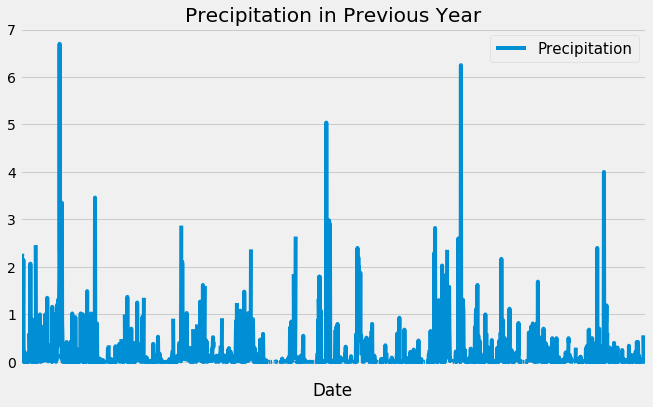

In [70]:
# Load results into dataframe
pcp_lists = {"Date": dates,
            "Precipitation": prcp_amounts}

precipitation = pd.DataFrame(pcp_lists).set_index('Date')

# Sort values in chronological order
precipitation = precipitation.sort_values('Date')

# Plot precipitation
pcp_plot = precipitation.plot(y='Precipitation', figsize=(10,6))
pcp_plot.axes.get_xaxis().set_ticks([])
plt.title('Precipitation in Previous Year')
plt.xlabel('Date')
plt.legend(prop={'size': 15})

In [71]:
# Print summary statistics of precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Temperature Analysis

In [72]:
# Count total number of stations
unique_stations = []
for station in session.query(Measurement.station).distinct():
    unique_stations.append(station)
print("There are a total of", len(unique_stations), "stations in the dataset.")

There are a total of 9 stations in the dataset.


In [73]:
# List the most active stations
active_stations = session.query(Measurement.station,func.count(Measurement.station))\
                                .group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Most active station information
print(f"The most active station is {active_stations [0][0]} with {active_stations[0][1]} observations.")
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"The min, max and avg temperatures recorded in this station are respectively: {min_temp}, {max_temp}, {avg_temp}")

The most active station is USC00519281 with 2772 observations.
The min, max and avg temperatures recorded in this station are respectively: [(54.0,)], [(85.0,)], [(71.66378066378067,)]


In [75]:
# Query the last twelve months of temperatures for the most active station
temperatures = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')\
                        .filter(Measurement.date >= '2016-08-23').all()
temperatures = pd.DataFrame(temperatures)

Text(0, 0.5, 'Frequency')

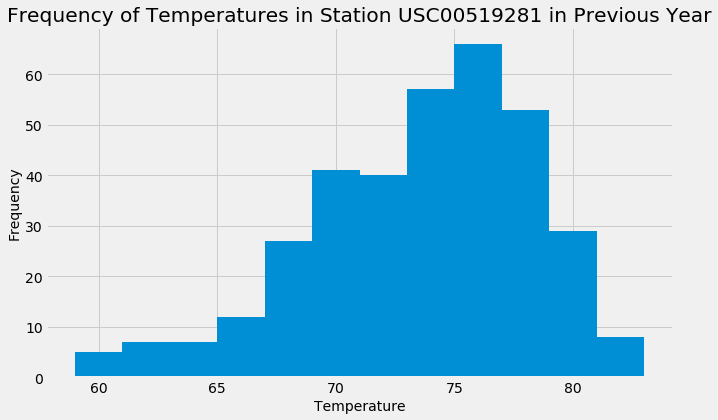

In [76]:
# Plot histogram of temparatures in most active station
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(temperatures.tobs,bins=12)
plt.title('Frequency of Temperatures in Station USC00519281 in Previous Year')
plt.xlabel('Temperature', fontsize='14')
plt.ylabel('Frequency', fontsize='14')

## Additional Temperature Analysis

In [77]:
# Average June temperatures in dataset
june_temps = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==6).all()
june_temp_avg = session.query(func.avg(Measurement.tobs)).filter(extract('month',Measurement.date)==6).all()

# Average December temperatures in dataset
dec_temps = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==12).all()
dec_temp_avg = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date)==12).all()

print(f"The average June temperature is {june_temp_avg}.")
print(f"The average December temperature is {dec_temp_avg}.")

The average June temperature is [(74.94411764705882,)].
The average December temperature is [(71.04152933421226,)].


<p> I will perform an unpaired (independent) t-test on the June and December temperature samples to determine if there is a statistically significant difference in average temperature in these months. An  unpaired t-test is conducted here because the samples come from different months of the years and are of different sizes.</p>

In [78]:
# Paired t-test on June and December average temperatures
stats.ttest_ind(june_temps, dec_temps)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

<p> This low p-value indicates there is strong evidence against the null hypothesis that the difference in these temperatures is due to chance. Therefore, we accept that the differences in the average temperature did not occur by chance.

### Vacation Analysis

In [96]:
# Use following function to determine the minimum, average, and maximum temperatures during given vacation dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
        .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

trip_temps = calc_temps('2017-05-20', '2017-05-31')

print(f"The min, avg, and max temperatures during the trip were respectively: {trip_temps[0][0]}, {trip_temps[0][1]}, {trip_temps[0][2]}")

The min, avg, and max temperatures during the trip were respectively: 69.0, 75.44117647058823, 87.0


Text(0.5, 1.0, 'Trip Avg Temp')

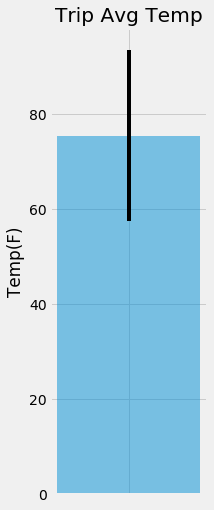

In [97]:
# Plot average temperature and minimum and maximum temperatures as error bar
fig, ax = plt.subplots(figsize=(2.5,8))
plt.bar('',trip_temps[0][1], alpha=0.5, yerr=18)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

In [100]:
# Determine total rainfall during given vacation dates
# Join Measurement and Station tables
cols = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rainfall = session.query(*cols).filter(Measurement.station == Station.station)\
                    .filter(Measurement.date >= '2017-05-20')\
                    .filter(Measurement.date <= '2017-05-31').group_by(Measurement.station)\
                    .order_by(desc(func.sum(Measurement.prcp))).all()

total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.2700000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.67),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.35000000000000003)]

In [109]:
# Calculate daily normals (min, avg, max temps) during given vacation dates

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [139]:
# Find daily normals for every date in vacation 
# first_day = dt.date(2017, 5, 20)
# last_day = dt.date(2017, 5, 31)
# day = dt.timedelta(days=1)
dates = ['05-20', '05-21', '05-22', '05-23', '05-24', '05-25', '05-26', '05-27', '05-28', '05-29', '05-30', '05-31']

normals = []

for day in dates:
    normals.append(daily_normals(day))
    
normals

[[(68.0, 73.89655172413794, 79.0)],
 [(64.0, 72.96428571428571, 80.0)],
 [(64.0, 74.45614035087719, 80.0)],
 [(68.0, 74.94827586206897, 87.0)],
 [(67.0, 73.94827586206897, 79.0)],
 [(68.0, 74.27586206896552, 79.0)],
 [(65.0, 74.03636363636363, 82.0)],
 [(65.0, 74.49090909090908, 80.0)],
 [(67.0, 74.27777777777777, 82.0)],
 [(64.0, 74.19607843137256, 80.0)],
 [(69.0, 74.33333333333333, 81.0)],
 [(68.0, 74.4, 81.0)]]

In [165]:
# Take information out of list
flat_list_normals = [item for sublist in normals for item in sublist]

# Unzip tuples
tmin, tavg, tmax = map(list, zip(*flat_list_normals))

# Create dates list
dates = session.query(Measurement.date).filter(Measurement.date >= '2017-05-20')\
                .filter(Measurement.date <= '2017-05-31').distinct().order_by(Measurement.date).all()

dates_list = [item for sublist in dates for item in sublist]

# Create dataframe
df_list = {'date': dates_list,
          'tmin': tmin,
          'tavg': tavg,
          'tmax': tmax}

daily_normals_df = pd.DataFrame(df_list).set_index('date')
daily_normals_df 

,tmin,tavg,tmax
date,,,
2017-05-20,68.0,73.896552,79.0
2017-05-21,64.0,72.964286,80.0
2017-05-22,64.0,74.456140,80.0
2017-05-23,68.0,74.948276,87.0
2017-05-24,67.0,73.948276,79.0
2017-05-25,68.0,74.275862,79.0
2017-05-26,65.0,74.036364,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-28,67.0,74.277778,82.0


Text(0, 0.5, 'Temperature(F)')

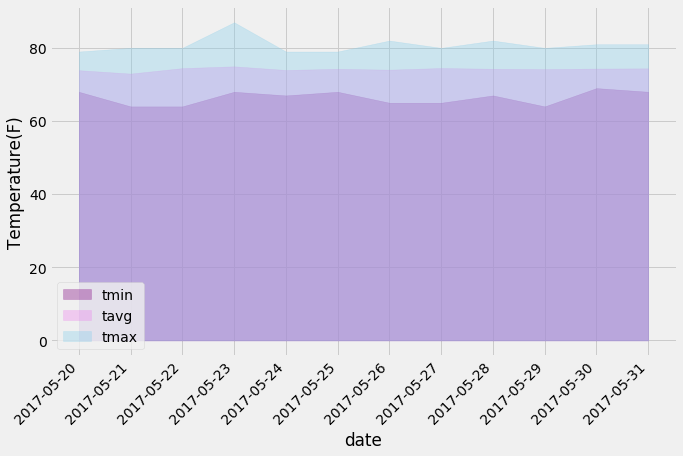

In [201]:
# Create stacked area chart of minimum, average, and max temperatures during the given vacation dates
figure, ax = plt.subplots(figsize=(10,6))
plt.fill_between(dates_list, tmin, color='purple', alpha=0.35, label='tmin')
plt.fill_between(dates_list, tavg, color='violet', alpha=0.35, label='tavg')
plt.fill_between(dates_list, tmax, color='skyblue', alpha=0.35, label='tmax')

plt.legend(loc="lower left")
plt.xticks(rotation=45, ha="right")
plt.xlabel('date')
plt.ylabel('Temperature(F)')
